**This notebook introduces how to train a random forest model to predict sea ice concentration from SST data in polar regions. <br/>**

Based on HadISST SST and Ice data

Reference: https://github.com/duncanwp/ClimateBench/blob/main/baseline_models/Original_RF_model.ipynb

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import xarray as xr
from pathlib import Path
import urllib.request
import gzip
import shutil

from sklearn.ensemble import RandomForestRegressor 
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from utils import * 

%matplotlib inline
%config InlineBackend.figure_format = 'retina'
%load_ext autoreload
%autoreload 2

plt.rcParams['savefig.dpi'] = 400
plt.rcParams['font.size'] = 13
plt.rcParams["legend.frameon"] = False

In [2]:
cwd = os.getcwd()
data_dir = Path("hadisst_data")
data_dir.mkdir(exist_ok=True)

### 0. Data Download and Preparation

In [3]:
# Download URLs
sst_url = "https://www.metoffice.gov.uk/hadobs/hadisst/data/HadISST_sst.nc.gz"
ice_url = "https://www.metoffice.gov.uk/hadobs/hadisst/data/HadISST_ice.nc.gz"

sst_gz = data_dir / "HadISST_sst.nc.gz"
ice_gz = data_dir / "HadISST_ice.nc.gz"
sst_nc = data_dir / "HadISST_sst.nc"
ice_nc = data_dir / "HadISST_ice.nc"

def download_if_needed(url, gz_path):
    if not gz_path.exists():
        print(f"  - Downloading {gz_path.name} ...")
        urllib.request.urlretrieve(url, gz_path)
    else:
        print(f"  - {gz_path.name} already exists, skipping download.")

def gunzip_if_needed(gz_path, nc_path):
    if not nc_path.exists():
        print(f"  - Decompressing {gz_path.name} -> {nc_path.name}")
        with gzip.open(gz_path, "rb") as f_in, open(nc_path, "wb") as f_out:
            shutil.copyfileobj(f_in, f_out)
    else:
        print(f"  - {nc_path.name} already exists, skipping decompression.")

# Download and decompress
download_if_needed(sst_url, sst_gz)
gunzip_if_needed(sst_gz, sst_nc)
download_if_needed(ice_url, ice_gz)
gunzip_if_needed(ice_gz, ice_nc)

# Load datasets
ds_sst = xr.open_dataset(sst_nc)
ds_ice = xr.open_dataset(ice_nc)

# Identify ice variable name
if "sic" in ds_ice.data_vars:
    ice_var = "sic"
elif "ice" in ds_ice.data_vars:
    ice_var = "ice"
else:
    ice_var = list(ds_ice.data_vars)[0]
    print(f"\n⚠️  Using '{ice_var}' as the ice variable (first data_var).")

# Merge into single dataset
ds_full = xr.merge([
    ds_sst[["sst"]],                            
    ds_ice[[ice_var]].rename({ice_var: "ice"}) 
])

# Filter to polar regions (Arctic: lat > 45, Antarctic: lat < -45)
ds_full = ds_full.where((ds_full.latitude > 45) | (ds_full.latitude < -45))

print(f"\nFiltered dataset to polar regions:")
print(f"  Latitude range: {ds_full.latitude.min().values:.2f}° to {ds_full.latitude.max().values:.2f}°")
print(f"  Number of latitude points: {len(ds_full.latitude)}")
print(f"\nThis focuses the analysis on regions where sea ice is predominantly found.")
print("="*70)

  - HadISST_sst.nc.gz already exists, skipping download.
  - HadISST_sst.nc already exists, skipping decompression.
  - HadISST_ice.nc.gz already exists, skipping download.
  - HadISST_ice.nc already exists, skipping decompression.

Filtered dataset to polar regions:
  Latitude range: -89.50° to 89.50°
  Number of latitude points: 180

This focuses the analysis on regions where sea ice is predominantly found.


### 1. Data preprocessing: prepare data for training & test sets

#### Import data as training & test sets

In [4]:
# Split data: training (before 2010), testing (2010 onwards)
train_end_year = '2010'
test_start_year = '2010'

ds_train = ds_full.sel(time=slice(None, train_end_year))
ds_test = ds_full.sel(time=slice(test_start_year, None))

print(f"Training data time range: {ds_train.time.values[0]} to {ds_train.time.values[-1]}")
print(f"Testing data time range: {ds_test.time.values[0]} to {ds_test.time.values[-1]}")
print(f"Training samples: {len(ds_train.time)}")
print(f"Testing samples: {len(ds_test.time)}")

Training data time range: 1870-01-16T11:59:59.505615234 to 2010-12-16T12:00:00.000000000
Testing data time range: 2010-01-16T12:00:00.000000000 to 2025-09-16T00:00:00.000000000
Training samples: 1692
Testing samples: 189


#### Select relevant variables

predictor: SST (sea surface temperature) <br/>
predictand: sea ice concentration

In [5]:
# Prepare Predictor Variables (X) - SST
print("-"*70)
print("Preparing predictor variables (X - SST)...")
print("-"*70)

# Stack SST data: reshape from (time, lat, lon) to (time, lat*lon)
X_train_xr = ds_train['sst']
X_test_xr = ds_test['sst']

# Convert to numpy and stack spatial dimensions
X_train_stacked = X_train_xr.stack(space=('latitude', 'longitude')).values
X_test_stacked = X_test_xr.stack(space=('latitude', 'longitude')).values

print(f"Training SST shape (stacked): {X_train_stacked.shape}")
print(f"Testing SST shape (stacked): {X_test_stacked.shape}")

# Prepare Predictand Variable (y) - ICE
print("\n" + "-"*70)
print("Preparing predictand variable (y - ICE extent)...")
print("-"*70)

y_train_xr = ds_train['ice']
y_test_xr = ds_test['ice']

# Stack spatial dimensions
y_train_stacked = y_train_xr.stack(space=('latitude', 'longitude')).values
y_test_stacked = y_test_xr.stack(space=('latitude', 'longitude')).values

print(f"Training ICE shape (stacked): {y_train_stacked.shape}")
print(f"Testing ICE shape (stacked): {y_test_stacked.shape}")

# Get lat/lon coordinates for features
print("\n" + "-"*70)
print("Creating spatial coordinate arrays...")
print("-"*70)

lat_values = ds_train.latitude.values
lon_values = ds_train.longitude.values
lat_grid, lon_grid = np.meshgrid(lat_values, lon_values, indexing='ij')
lat_flat = lat_grid.flatten()
lon_flat = lon_grid.flatten()

print(f"Spatial dimensions: {len(lat_values)} lat x {len(lon_values)} lon = {len(lat_flat)} total points")

# Create features (SST + Lat + Lon)
print("\n" + "-"*70)
print("Creating features (SST + Lat + Lon)...")
print("-"*70)

# Flatten SST
sst_train_flat = X_train_stacked.flatten()
sst_test_flat = X_test_stacked.flatten()

# Repeat lat/lon for each time step
n_time_train = len(ds_train.time)
n_time_test = len(ds_test.time)
lat_train_flat = np.tile(lat_flat, n_time_train)
lon_train_flat = np.tile(lon_flat, n_time_train)
lat_test_flat = np.tile(lat_flat, n_time_test)
lon_test_flat = np.tile(lon_flat, n_time_test)

# Stack into feature matrix: [SST, Lat, Lon]
X_train = np.column_stack([sst_train_flat, lat_train_flat, lon_train_flat])
X_test = np.column_stack([sst_test_flat, lat_test_flat, lon_test_flat])

# Targets: ICE values flattened
y_train = y_train_stacked.flatten()
y_test = y_test_stacked.flatten()

print(f"Training data created: {X_train.shape[0]} samples")
print(f"Features: [SST, Latitude, Longitude]")
print(f"Test data shape: X={X_test.shape}, y={y_test.shape}")

# Remove NaN values (land or missing data)
print("\nRemoving NaN values...")
train_valid = ~(np.isnan(X_train).any(axis=1) | np.isnan(y_train))
test_valid = ~(np.isnan(X_test).any(axis=1) | np.isnan(y_test))

X_train = X_train[train_valid]
y_train = y_train[train_valid]
X_test = X_test[test_valid]
y_test = y_test[test_valid]

print(f"After removing NaNs:")
print(f"  Training: {X_train.shape[0]} valid samples")
print(f"  Testing: {X_test.shape[0]} valid samples")

----------------------------------------------------------------------
Preparing predictor variables (X - SST)...
----------------------------------------------------------------------
Training SST shape (stacked): (1692, 64800)
Testing SST shape (stacked): (189, 64800)

----------------------------------------------------------------------
Preparing predictand variable (y - ICE extent)...
----------------------------------------------------------------------
Training ICE shape (stacked): (1692, 64800)
Testing ICE shape (stacked): (189, 64800)

----------------------------------------------------------------------
Creating spatial coordinate arrays...
----------------------------------------------------------------------
Spatial dimensions: 180 lat x 360 lon = 64800 total points

----------------------------------------------------------------------
Creating features (SST + Lat + Lon)...
----------------------------------------------------------------------
Training data created: 10964

#### Data normalization

In [6]:
# Standardization
print("-"*70)
print("Normalizing data...")
print("-"*70)

# Calculate mean and std from training data only
mean = X_train.mean(axis=0)
std = X_train.std(axis=0)

# Standardize both train and test
X_train = (X_train - mean) / std
X_test = (X_test - mean) / std

print(f"Feature means: {mean}")
print(f"Feature stds: {std}")
print(f"\nX_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}")

----------------------------------------------------------------------
Normalizing data...
----------------------------------------------------------------------
Feature means: [-80.19013    6.554265  -9.818988]
Feature stds: [255.64563   65.516136 104.77128 ]

X_train shape: (32019408, 3)
y_train shape: (32019408,)
X_test shape: (3576636, 3)


### 2. Build & train the RF model

#### Option 1: randomly select a hyperparameter setting

In [13]:
n_estimators      = 15    # Number of trees in random forest
min_samples_split = 5    # Minimum number of samples required to split a node
min_samples_leaf  = 4      # Minimum number of samples required at each leaf node
max_features      = None  # Number of features to consider at every split: 'sqrt', 'log2', or None.
                           # None: max_features=n_features
max_depth         = 50     # Maximum number of levels in tree
bootstrap         = True   # Method of selecting samples for training each tree

reg0 = RandomForestRegressor(n_estimators=n_estimators,
                             min_samples_split=min_samples_split,
                             min_samples_leaf=min_samples_leaf,
                             max_features=max_features,
                             max_depth=max_depth,
                             bootstrap=bootstrap,
                             n_jobs=-1,
                             verbose=1)

print("Training Random Forest model...")
rf_sic = reg0.fit(X_train, y_train)
print("Training complete!")

Training Random Forest model...


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.


Training complete!


[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed:  3.7min finished


#### Option 2: use **cross validation** to find the optimum hyperparameter setting

In [15]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 10, stop = 50, num = 5)]

# Number of features to consider at every split
max_features = ['sqrt', 'log2', None]

# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(5, 55, num = 11)]
max_depth.append(None)

# Minimum number of samples required to split a node
min_samples_split = [5, 10, 15, 25]

# Minimum number of samples required at each leaf node
min_samples_leaf = [4, 8, 12, 16]

# Method of selecting samples for training each tree
bootstrap = [True, False]

# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

In [16]:
print(random_grid)

{'n_estimators': [10, 20, 30, 40, 50], 'max_features': ['sqrt', 'log2', None], 'max_depth': [5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, None], 'min_samples_split': [5, 10, 15, 25], 'min_samples_leaf': [4, 8, 12, 16], 'bootstrap': [True, False]}


In [17]:
reg0 = RandomForestRegressor(random_state=42, n_jobs=-1)
# Perform cross validation
rf_random0 = RandomizedSearchCV(estimator = reg0, param_distributions = random_grid, 
                                n_iter = 5, cv = 3, verbose=2, n_jobs = -1)
rf_sic = rf_random0.fit(X_train, y_train)

print("\nThe best hyperparameters: \n", rf_sic.best_params_)

Fitting 3 folds for each of 5 candidates, totalling 15 fits


KeyboardInterrupt: 

### 3. Evaluate the model

In [19]:
# Make predictions
print("Making predictions on test set...")
y_test_pred = rf_sic.predict(X_test)

# Calculate metrics
print("\nCalculating performance metrics...")
rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
mae = mean_absolute_error(y_test, y_test_pred)
r2 = r2_score(y_test, y_test_pred)

print("\nPerformance Metrics:")
print(f"  RMSE: {rmse:.6f}")
print(f"  MAE: {mae:.6f}")
print(f"  R² Score: {r2:.6f}")

# Reshape predictions back to spatial format for visualization
print("\nReshaping predictions to spatial format...")

# Create a full array with NaNs for all spatial points
n_time_test = len(ds_test.time)
n_lat = len(ds_test.latitude)
n_lon = len(ds_test.longitude)

# Initialize with NaN
ice_pred_full = np.full((n_time_test, n_lat, n_lon), np.nan)

# Fill in the valid predictions
# Map test_valid indices back to original positions
test_valid_reshaped = test_valid.reshape(n_time_test, n_lat, n_lon)
ice_pred_full[test_valid_reshaped] = y_test_pred

# Create xarray dataset
y_test_pred_xr = xr.Dataset(
    {
        'ice': (['time', 'latitude', 'longitude'], ice_pred_full)
    },
    coords={
        'time': ds_test.time,
        'latitude': ds_test.latitude,
        'longitude': ds_test.longitude
    }
)

print(f"Prediction dataset shape: {y_test_pred_xr.ice.shape}")


# Feature importance
print("\nFeature Importances:")
feature_names = ['SST', 'Latitude', 'Longitude']
for i, name in enumerate(feature_names):
    print(f"  {name}: {rf_sic.feature_importances_[i]:.4f}")

Making predictions on test set...


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  15 out of  15 | elapsed:    1.7s finished



Calculating performance metrics...

Performance Metrics:
  RMSE: 0.083656
  MAE: 0.027813
  R² Score: 0.966498

Reshaping predictions to spatial format...
Prediction dataset shape: (189, 180, 360)

Feature Importances:
  SST: 0.9695
  Latitude: 0.0201
  Longitude: 0.0104


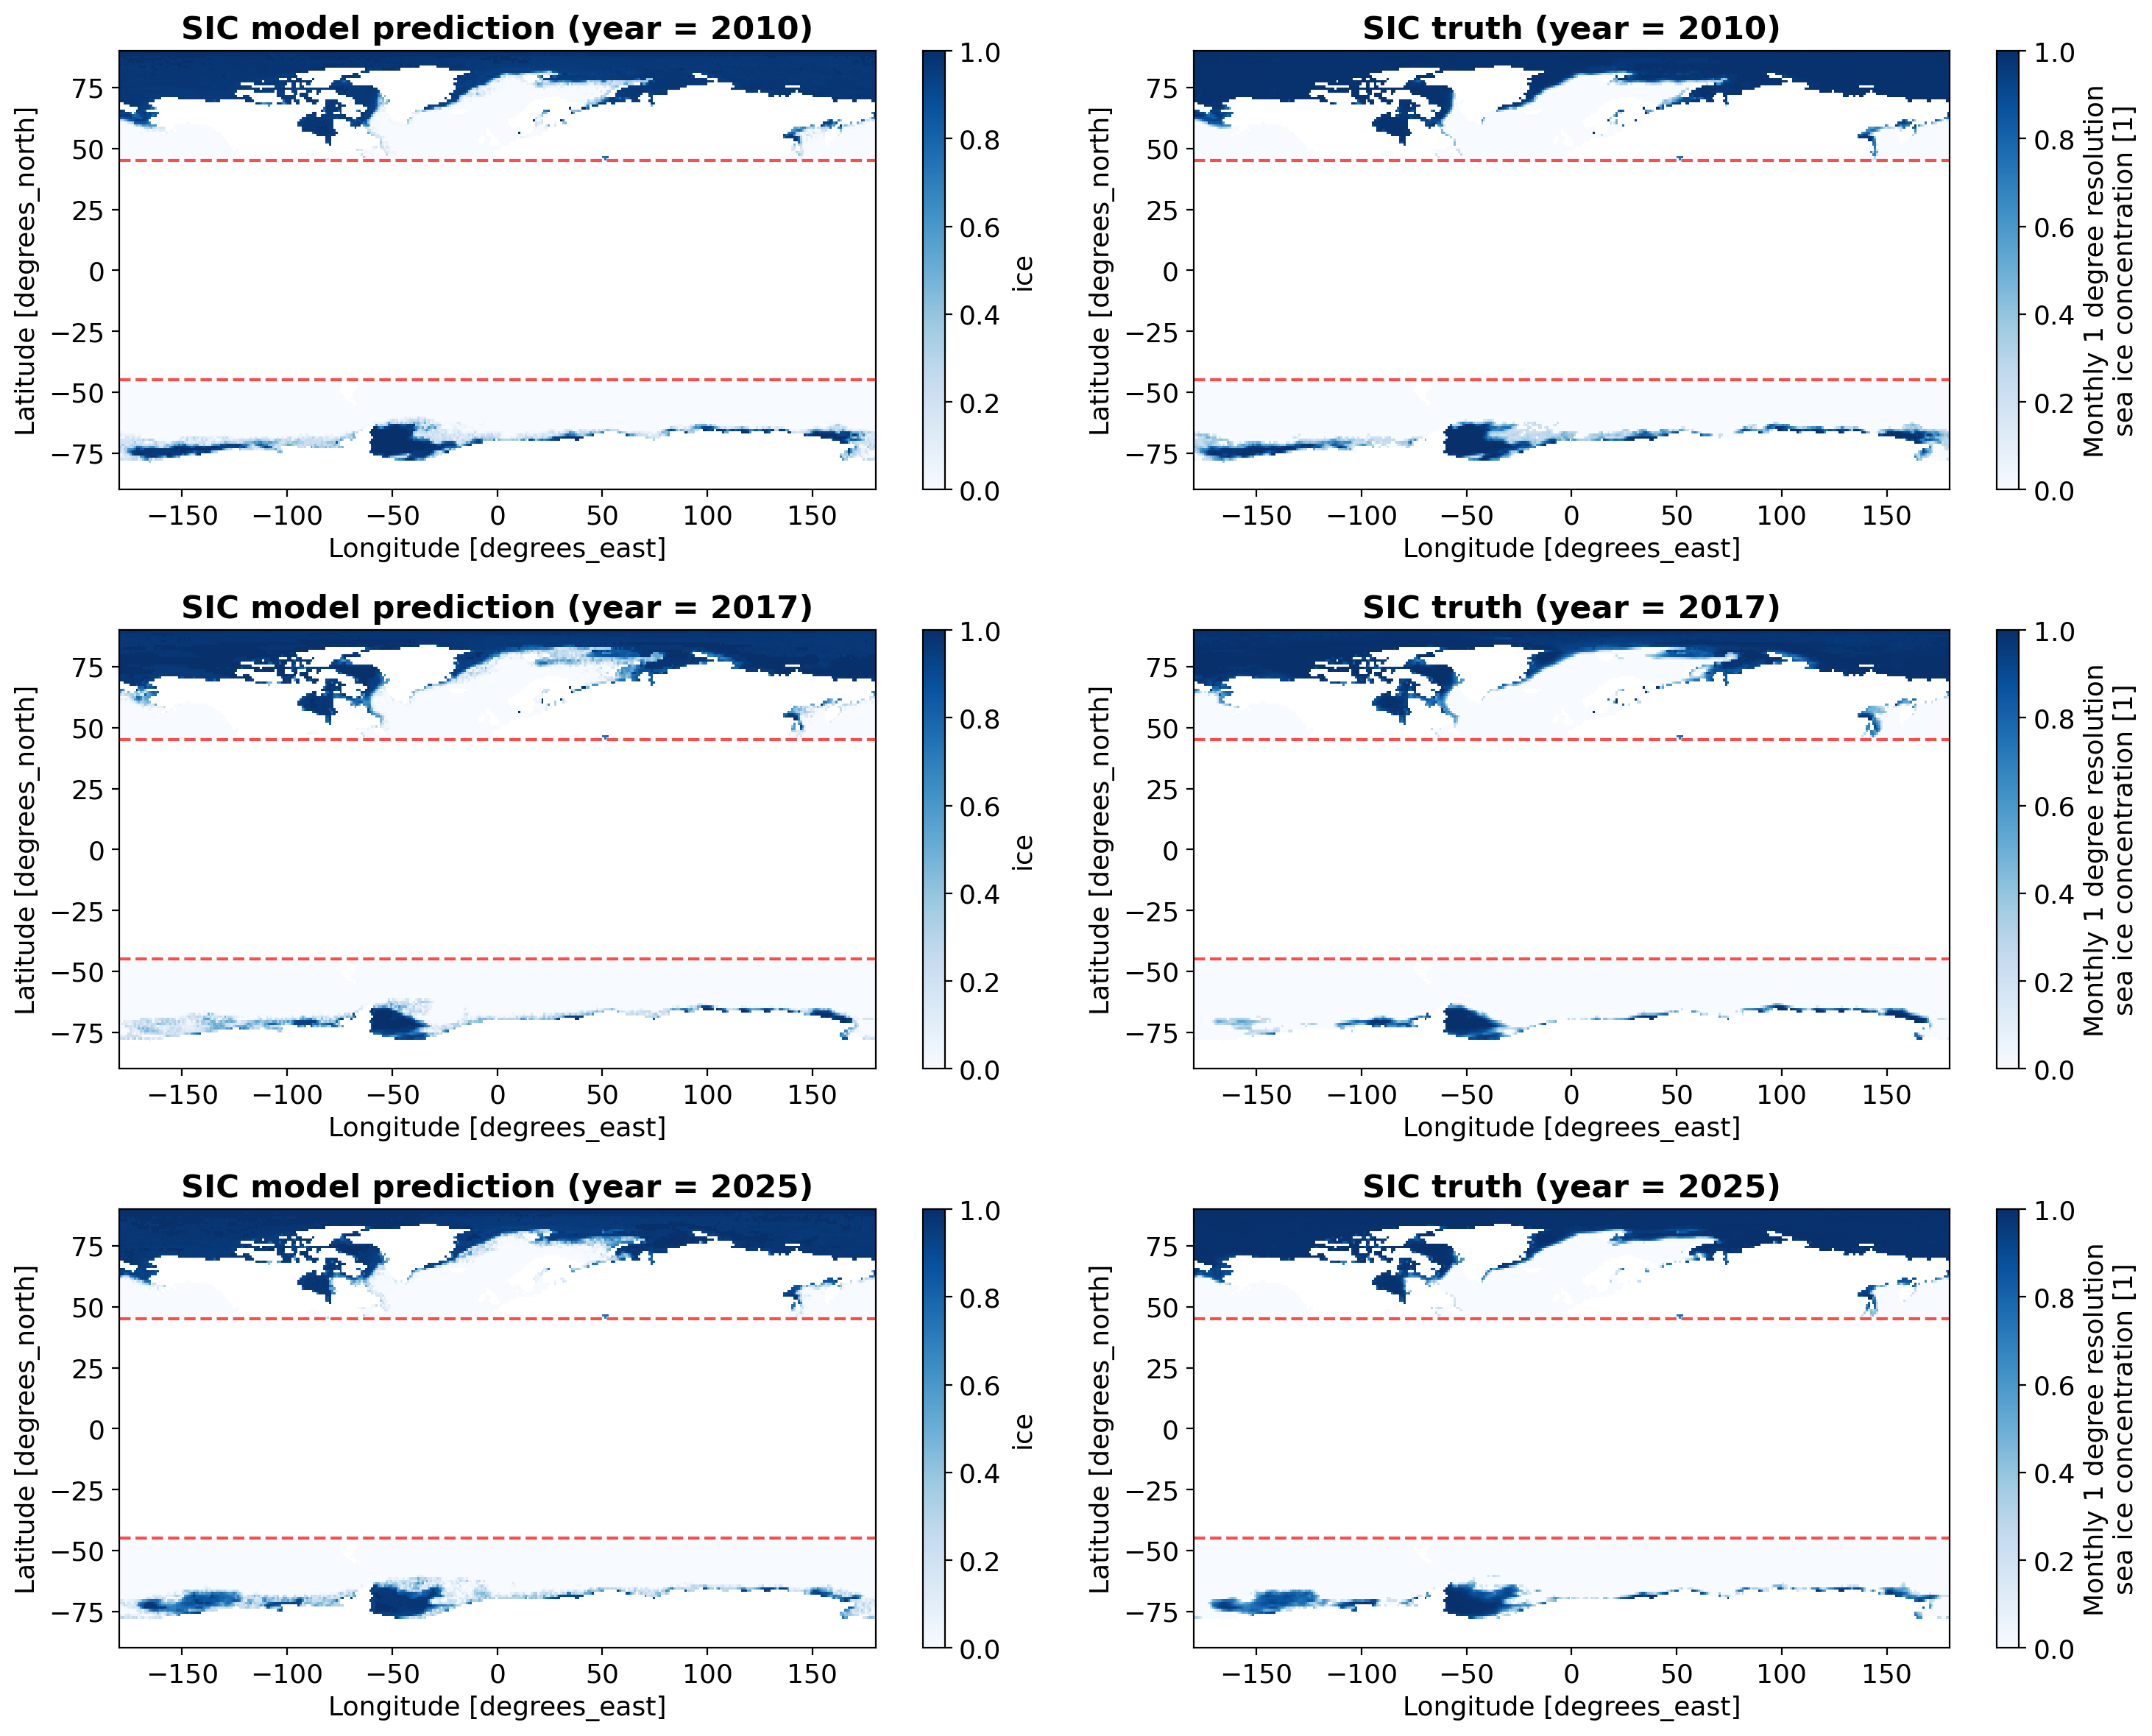

In [18]:
# Visualize predictions vs truth for selected years
fig, axes = plt.subplots(figsize=(15, 12), ncols=2, nrows=3)

# Select years to visualize
test_years = ds_test.time.dt.year.values
yrs = [test_years[0], test_years[len(test_years)//2], test_years[-1]]  # First, middle, last

vmin, vmax = 0, 1  # Sea ice concentration ranges from 0 to 1
cmap = 'Blues'

# Plot predictions and truth for each year
y_test_pred_xr.ice.sel(time=f"{yrs[0]}", method='nearest').plot(
    ax=axes[0,0], vmin=vmin, vmax=vmax, cmap=cmap)
ds_test.ice.sel(time=f"{yrs[0]}", method='nearest').plot(
    ax=axes[0,1], vmin=vmin, vmax=vmax, cmap=cmap)

y_test_pred_xr.ice.sel(time=f"{yrs[1]}", method='nearest').plot(
    ax=axes[1,0], vmin=vmin, vmax=vmax, cmap=cmap)
ds_test.ice.sel(time=f"{yrs[1]}", method='nearest').plot(
    ax=axes[1,1], vmin=vmin, vmax=vmax, cmap=cmap)

y_test_pred_xr.ice.sel(time=f"{yrs[2]}", method='nearest').plot(
    ax=axes[2,0], vmin=vmin, vmax=vmax, cmap=cmap)
ds_test.ice.sel(time=f"{yrs[2]}", method='nearest').plot(
    ax=axes[2,1], vmin=vmin, vmax=vmax, cmap=cmap)

# Set titles and add red lines at cutoff latitudes
for i, ax in enumerate(axes.flat):
    if i % 2 == 0:
        ax.set_title(f'SIC model prediction (year = {yrs[i//2]})', fontweight='bold')
    else:
        ax.set_title(f'SIC truth (year = {yrs[i//2]})', fontweight='bold')
    
    # Add red horizontal lines at ±45° latitude cutoffs
    ax.axhline(45, color='red', linestyle='--', linewidth=1.5, alpha=0.7)
    ax.axhline(-45, color='red', linestyle='--', linewidth=1.5, alpha=0.7)

plt.tight_layout()

Calculating spatial RMSE map...


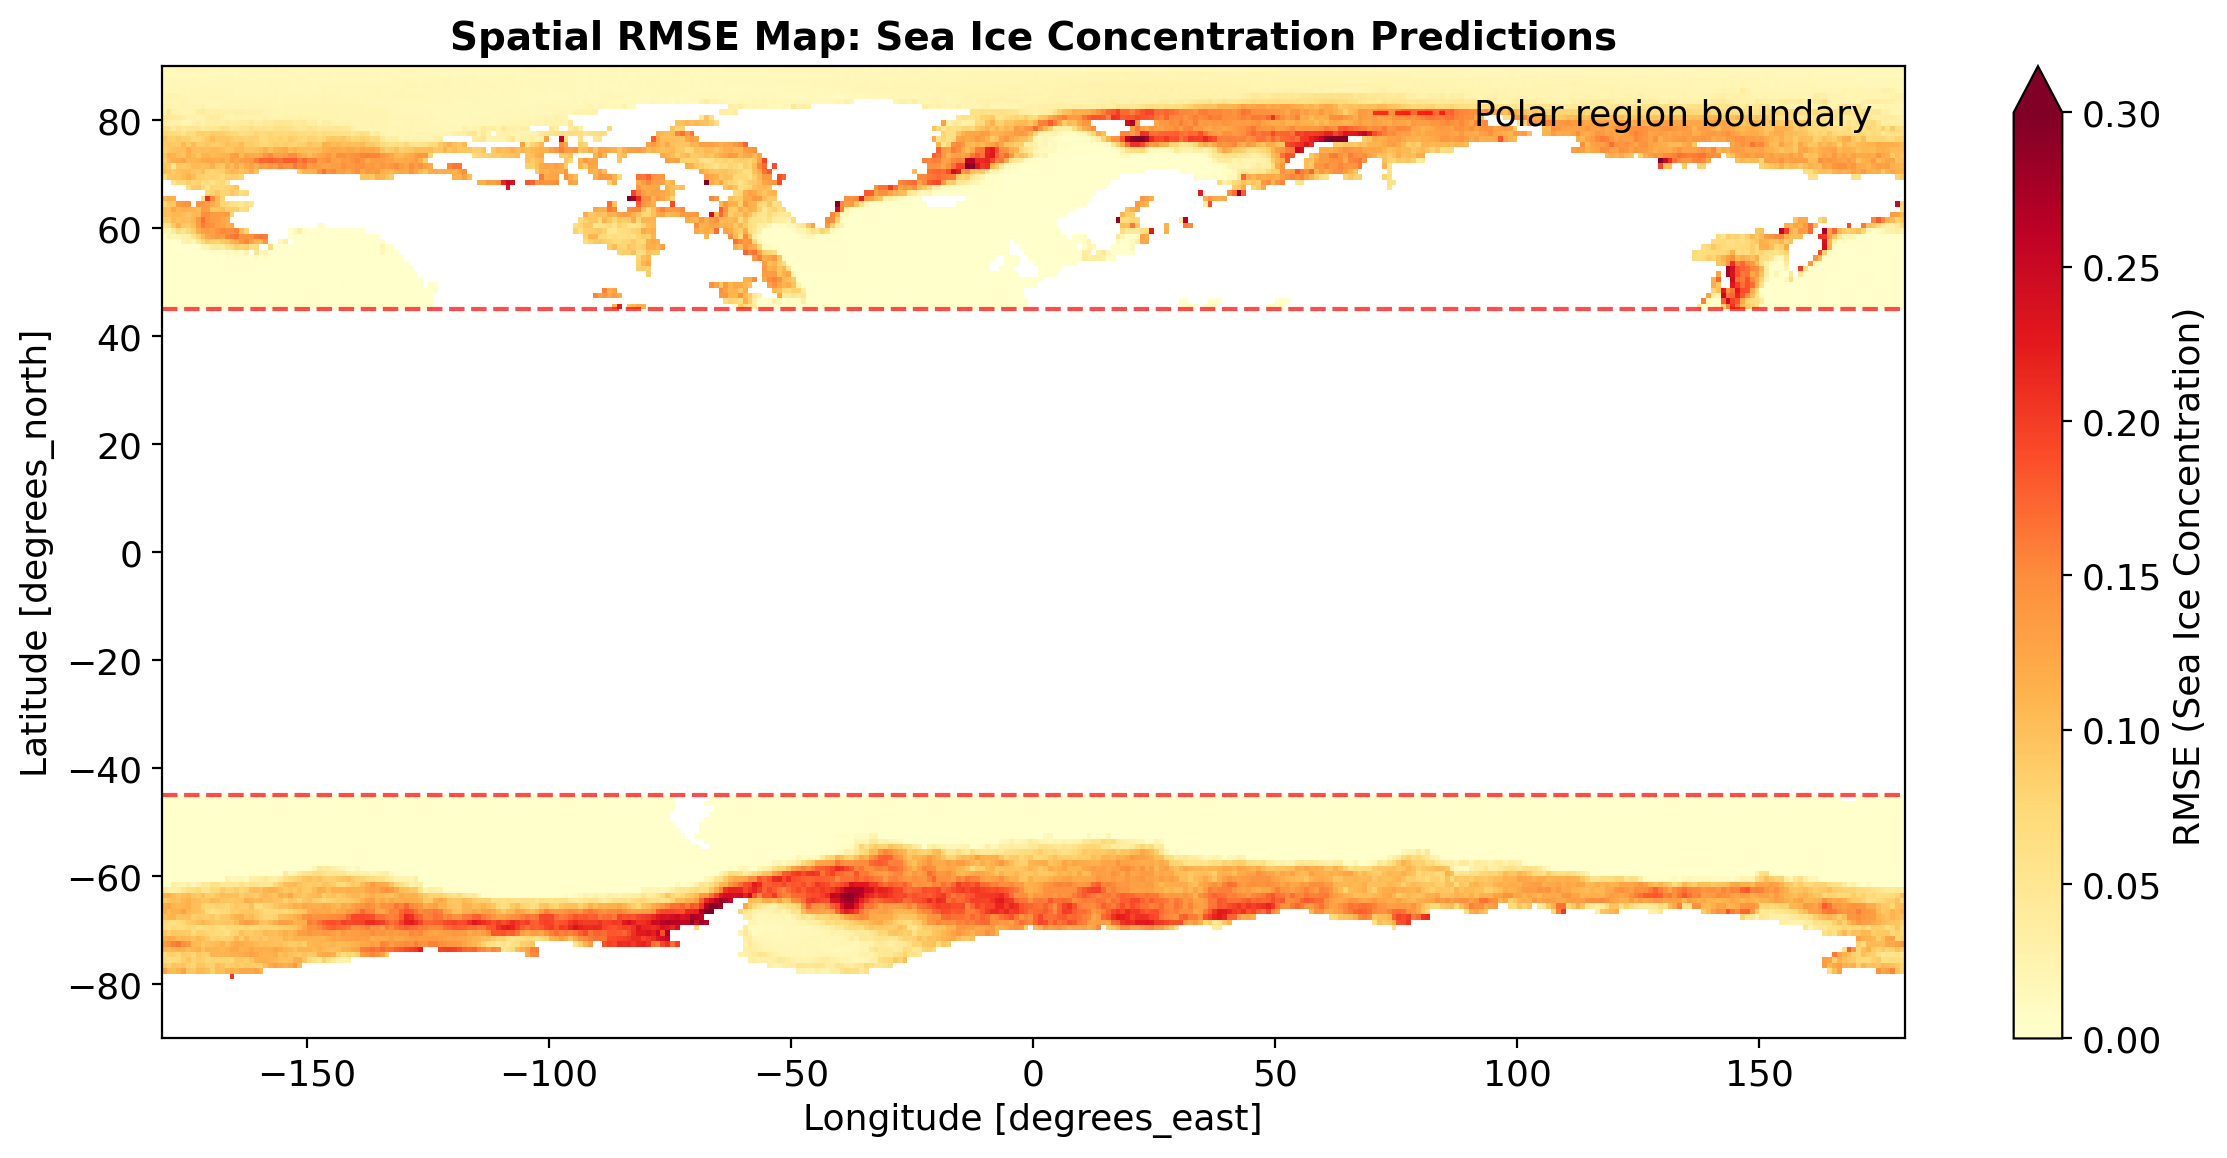

In [17]:
# Calculate spatial RMSE map (RMSE at each grid point across all time steps)
print("Calculating spatial RMSE map...")

# Calculate squared differences at each grid point for each time step
squared_diff = (y_test_pred_xr.ice - ds_test.ice) ** 2

# Calculate RMSE at each spatial location (mean over time, then sqrt)
spatial_rmse = np.sqrt(squared_diff.mean(dim='time', skipna=True))

# Create the spatial RMSE plot
fig, ax = plt.subplots(figsize=(12, 6))

# Plot the spatial RMSE
spatial_rmse.plot(ax=ax, cmap='YlOrRd', vmin=0, vmax=0.3, 
                  cbar_kwargs={'label': 'RMSE (Sea Ice Concentration)'})

# Add red lines at polar cutoff
ax.axhline(45, color='red', linestyle='--', linewidth=1.5, alpha=0.7, label='Polar region boundary')
ax.axhline(-45, color='red', linestyle='--', linewidth=1.5, alpha=0.7)

ax.set_title('Spatial RMSE Map: Sea Ice Concentration Predictions', fontweight='bold', fontsize=14)
ax.set_xlabel('Longitude [degrees_east]')
ax.set_ylabel('Latitude [degrees_north]')
ax.legend()

plt.tight_layout()
plt.show()



In [11]:
# Calculate RMSE for Greenland region
lon_min, lon_max = -55, -20
lat_min, lat_max = 60, 85

print(f"Greenland region:")
print(f"  Latitude: {lat_min} to {lat_max} °N")
print(f"  Longitude: {lon_min} to {lon_max} °E")

# Build region mask
lat_cond = (ds_test.latitude >= lat_min) & (ds_test.latitude <= lat_max)
lon_cond = (ds_test.longitude >= lon_min) & (ds_test.longitude <= lon_max)
region_mask = lat_cond & lon_cond

# Apply mask
sic_true_region = ds_test.ice.where(region_mask)
sic_pred_region = y_test_pred_xr.ice.where(region_mask)

# RMSE over time & space
rmse_greenland = np.sqrt(((sic_pred_region - sic_true_region) ** 2).mean(skipna=True))

print(f"\nRMSE for Greenland region: {float(rmse_greenland):.4f}")

# Optional: Calculate additional metrics for this region
mae_greenland = np.abs(sic_pred_region - sic_true_region).mean(skipna=True)
print(f"MAE for Greenland region: {float(mae_greenland):.4f}")

Greenland region:
  Latitude: 60 to 85 °N
  Longitude: -55 to -20 °E

RMSE for Greenland region: 0.1154
MAE for Greenland region: 0.0506
